# Selecting a location for a oil well

The mining company needs to decide where to drill a new well.

Oil samples were provided in three regions: in each 10,000 fields, where the quality of oil and the volume of its reserves were measured.
The task is to build a machine learning model that will help determine the region where mining will bring the greatest profit.
It is necessary to analyze the possible profits and risks of the *Bootstrap.* technique

Steps to select a location:
- We are looking for deposits in the selected region, and for each we determine the characteristic values;
- We build a model and estimate the volume of reserves;
- We select deposits with the highest estimated values. The number of fields depends on the company’s budget and the cost of developing one well;
- Profit is equal to the total profit of the selected fields.

## Loading and preparing data

### Introduction

**Geological exploration data for three regions is in the files:**

- geo_data_0.csv
- geo_data_1.csv
- geo_data_2.csv

**id - unique well identifier;**

**f0, f1, f2 - three signs of points (it doesn’t matter what they mean, but the signs themselves are significant);**

**product - volume of reserves in the well (thousand barrels) - target attribute.**

**Conditions of the problem:**
Only linear regression is suitable for training the model (the others are not predictable enough).
When exploring a region, 500 points are examined, from which, using machine learning, the best 200 are selected for development.
The budget for well development in the region is 10 billion rubles.
At current prices, one barrel of raw materials brings 450 rubles in income. The income from each unit of product is 450 thousand rubles, since the volume is indicated in thousands of barrels.
After assessing the risks, you need to leave only those regions in which the probability of losses is less than 2.5%. Among them, the region with the highest average profit is selected.
The data is synthetic: details of contracts and characteristics of the fields are not disclosed.

### We will prepare the libraries necessary for the work

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error

from google.colab import drive

### Let's study the data inside the dataframe and do the necessary preprocessing

In [4]:
#function for not to duplicate everything several times
def show_info(link):
     data = pd.read_csv(link) #read data for 1 region into the data variable
     print(link)
     display(data.head()); #display the first 5 rows of the dataset
     display(data.info()); #display information about data types and gaps in the dataset
     display(data.describe()); #display information about the distribution of values in the dataset
     display(data.corr(numeric_only=True)); #let's look at the correlation between features
     print('\n\n')

QTY_REGIONS = 3 # number of regions
drive.mount('/content/drive')

for i in range(QTY_REGIONS):
     show_info(f'/content/drive/My Drive/projects/oil_wells_profitability_prediction/geo_data_{i}.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/projects/oil_wells_profitability_prediction/geo_data_0.csv


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000





/content/drive/My Drive/projects/oil_wells_profitability_prediction/geo_data_1.csv


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000





/content/drive/My Drive/projects/oil_wells_profitability_prediction/geo_data_2.csv


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


**We see that the data for each region does not have gaps or any anomalies in types that require corrections.**

**A rather strange moment is the almost complete correlation in the data of region 2 of two features: the f2 feature and the target product feature.**

**Remove the non-informative `'id'` attribute from each dataset.**

In [5]:
# function that removes the required feature from each dataset in the list
def delete_column(link_list, column):
     for i in range(len(link_list)):
         df = pd.read_csv(link_list[i])
         df = df.drop([column], axis=1)
         df_list.append(df)
     return df_list

link_list = [] # create a list for dataset links
df_list = [] # create a list of dataframes

#fill in the list of dataset links
for i in range(QTY_REGIONS):
     link_list.append(f'/content/drive/My Drive/projects/oil_wells_profitability_prediction/geo_data_{i}.csv')

#fill the list of dataframes
df_list = delete_column(link_list, 'id')
df_list

[             f0        f1        f2     product
 0      0.705745 -0.497823  1.221170  105.280062
 1      1.334711 -0.340164  4.365080   73.037750
 2      1.022732  0.151990  1.419926   85.265647
 3     -0.032172  0.139033  2.978566  168.620776
 4      1.988431  0.155413  4.751769  154.036647
 ...         ...       ...       ...         ...
 99995  0.971957  0.370953  6.075346  110.744026
 99996  1.392429 -0.382606  1.273912  122.346843
 99997  1.029585  0.018787 -1.348308   64.375443
 99998  0.998163 -0.528582  1.583869   74.040764
 99999  1.764754 -0.266417  5.722849  149.633246
 
 [100000 rows x 4 columns],
               f0         f1        f2     product
 0     -15.001348  -8.276000 -0.005876    3.179103
 1      14.272088  -3.475083  0.999183   26.953261
 2       6.263187  -5.948386  5.001160  134.766305
 3     -13.081196 -11.506057  4.999415  137.945408
 4      12.702195  -8.147433  5.004363  134.766305
 ...          ...        ...       ...         ...
 99995   9.535637  -6.878

## Model training and testing

### Dividing data into samples

**Divide the data for each of the 3 regions into training and validation samples in a ratio of 75:25, scale the numerical characteristics.**

In [7]:
# function that scales features
# and splits the list of datasets into lists of training samples and validation samples
def data_dev_std(df_list, target_column, test_size, numeric):
     pd.options.mode.chained_assignment = None # to "neutralize" a standardization error
     features_train_list = []
     features_valid_list = []
     target_train_list = []
     target_valid_list = []
     i = 0
     # divide the dataset into training and validation samples
     for df in df_list:
         target = df[target_column]
         features = df.drop([target_column], axis = 1)
         features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=test_size, random_state=i)
         # normalize numerical features
         scaler = StandardScaler()
         scaler.fit(features_train[numeric])
         features_train[numeric] = scaler.transform(features_train[numeric])
         features_valid[numeric] = scaler.transform(features_valid[numeric])
         # write the resulting samples into the corresponding lists
         features_train_list.append(features_train)
         features_valid_list.append(features_valid)
         target_train_list.append(target_train)
         target_valid_list.append(target_valid)
         i += 1
     return features_train_list, features_valid_list, target_train_list, target_valid_list

features_train_list = []
features_valid_list = []
target_train_list = []
target_valid_list = []

features_train_list, features_valid_list, target_train_list, target_valid_list = data_dev_std(df_list, 'product', 0.25, ['f0', 'f1', 'f2'])

# function takes a number and returns the appropriate suffix
def add_suffix(num):
    if num == 1:
        return f"{num}st"
    elif num == 2:
        return f"{num}nd"
    elif num == 3:
        return f"{num}rd"
    else:
        return f"{num}th"

# display the sizes of the resulting samples
for i in range(QTY_REGIONS):
     print('\n')
     print(f'{add_suffix(i+1)} region. features_train:')
     display(features_train_list[i].shape)
     print(f'{add_suffix(i+1)}  region. features_valid:')
     display(features_valid_list[i].shape)
     print(f'{add_suffix(i+1)}  region. target_train:')
     display(target_train_list[i].shape)
     print(f'{add_suffix(i+1)}  region. target_valid:')
     display(target_valid_list[i].shape)



1st region. features_train:


(75000, 3)

1st  region. features_valid:


(25000, 3)

1st  region. target_train:


(75000,)

1st  region. target_valid:


(25000,)



2nd region. features_train:


(75000, 3)

2nd  region. features_valid:


(25000, 3)

2nd  region. target_train:


(75000,)

2nd  region. target_valid:


(25000,)



3rd region. features_train:


(75000, 3)

3rd  region. features_valid:


(25000, 3)

3rd  region. target_train:


(75000,)

3rd  region. target_valid:


(25000,)

### Training models for each region and making predictions on validation
### Saving predictions and correct answers on the validation set
### Displays average inventory of predicted raw materials and RMSE of each model

In [8]:
predictions_valid_list = [] # list with predictions for each region on validation samples
rmse_list = [] # list with RMSE values for predictions of each model for each region on validation data
mean_pred_oil_reserves_list = [] # list with the values of the average reserve of predicted raw materials for each region

for i in range(QTY_REGIONS):
     model = LinearRegression() # initialize the LinearRegression model
     model.fit(features_train_list[i], target_train_list[i]) # train the model using the training set
     # get model predictions on the validation set and add to the list
     predictions_valid_list.append(model.predict(features_valid_list[i]))
     # get the value of the rmse metric for each model on the validation data and add it to the list
     rmse_list.append(mean_squared_error(target_valid_list[i], predictions_valid_list[i], squared=False))
     mean_pred_oil_reserves_list.append(predictions_valid_list[i].mean())

     # list of RMSE values for models trained for each region
print(f'RMSE for regions, thousand barrels:{[round(rmse, 3) for rmse in rmse_list]}')
# list of average reserves of predicted raw materials by region
print(f'Average reserves of predicted oil by region, thousand barrels:{[round(feedstock, 3) for feedstock in mean_pred_oil_reserves_list]}')

RMSE for regions, thousand barrels:[37.481, 0.894, 39.985]
Average reserves of predicted oil by region, thousand barrels:[92.271, 69.12, 94.86]


### Analysis of results

**The results obtained allow us to draw the following conclusions:**
- Regions 3 and 1 have the highest values of the average stock of predicted raw materials, however, taking into account the RMSE value for each of the models, the results are not so clear, because taking into account the error, the average stock of predicted raw materials may be the largest for region 2.
- The RMSE metric has the best (smallest) value for the model trained on data from region 2, which is logical, because At the beginning, we found a complete correlation between the f2 feature and the target feature for a given region.

## Preparation for profit calculation

### Save all key values for calculations in separate variables

When exploring a region, 500 points are examined, from which, using machine learning, the best 200 are selected for development.
The budget for well development in the region is 10 billion rubles.
At current prices, one barrel of raw materials brings 450 rubles in income. The income from each unit of product is 450 thousand rubles, since the volume is indicated in thousands of barrels.

In [9]:
ONE_REGION_BUDGET = 10 ** 10 # budget for well development in one region
ONE_UNIT_INCOME = 4.5 * 10 ** 5 # income per unit of product (1 thousand barrels)
EXPLORE_COUNT = 500 # number of points when exploring the region
TOP_COUNT = 200 # number of best points for development

### Calculate the sufficient volume of raw materials for the break-even development of a new well

Distribution of raw materials reserves for the 1st region


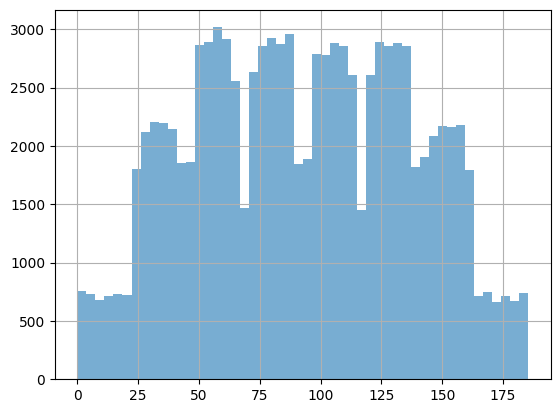



Distribution of raw materials reserves for the 2nd region


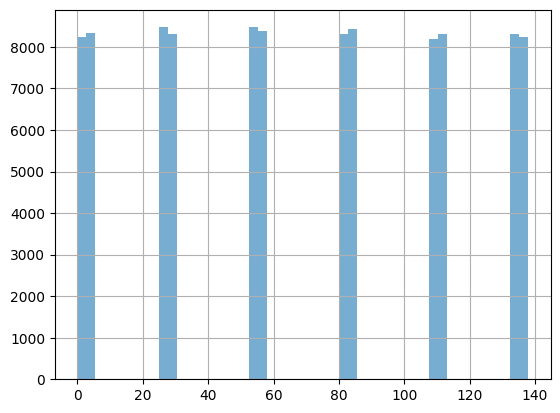



Distribution of raw materials reserves for the 3rd region


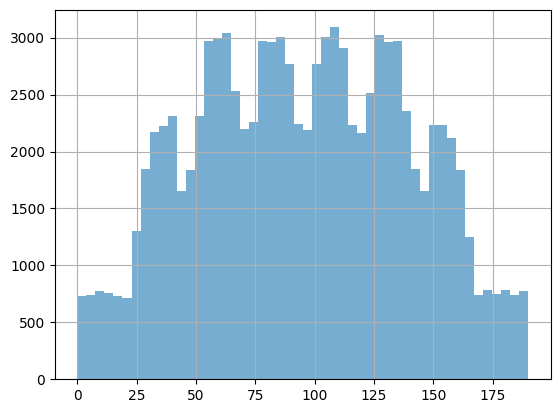



Average reserves in wells by region, thousand barrels:[92.5, 68.825, 95.0]
Sufficient volume of raw materials for break-even development of a new well 111.111 thousand barrels


In [12]:
mean_oil_reserves_list = [] # list of average reserves of raw materials by region
for i in range(QTY_REGIONS):
     mean_oil_reserves_list.append(df_list[i]['product'].mean())
     print(f'Distribution of raw materials reserves for the {add_suffix(i+1)} region')
     df_list[i]['product'].hist(bins=50, alpha=0.6)
     plt.show()
     print('\n')

print(f'Average reserves in wells by region, thousand barrels:{[round(oil, 3) for oil in mean_oil_reserves_list]}')
brkevn_amnt = ONE_REGION_BUDGET / TOP_COUNT / ONE_UNIT_INCOME
print(f'Sufficient volume of raw materials for break-even development of a new well {brkevn_amnt:.3f} thousand barrels')

### Comparison of the received volume of raw materials with the average stock in each region

**We see that the sufficient volume of raw materials to break even for one well exceeds the average values for each region.**

### Conclusions on the stage of preparing the profit calculation.

**We can conclude that despite the fact that the average volumes of raw materials in the regions are not sufficient for the break-even development of new 200 wells, based on the histogram, the probability of getting to 200 wells that will break even is not zero and at first glance is higher for region 1 and 3 .**

## Calculation of profits and risks

### Let's select wells with maximum prediction values
### Let's sum up the target value of the volume of raw materials corresponding to these predictions
### Let's calculate the profit for the received volume of raw materials

In [13]:
# function to calculate profit for wells with max. model prediction values
def profit_calc(predictions, target, count, one_unit_income, budget):
     pred_index = predictions.sort_values(ascending=False).iloc[:count].index
     target_top = target.reset_index(drop=True).iloc[predictions.sort_values(ascending=False).iloc[:count].index]
     target_sum_value = target_top.sum()
     target_sum_income = target_sum_value * one_unit_income - budget
     return target_sum_income

target_top_income_list = [] # list of total income with top 200 wells for each region
for i in range(QTY_REGIONS):
     target_top_income_list.append(
         profit_calc(pd.Series(predictions_valid_list[i]), target_valid_list[i], TOP_COUNT, ONE_UNIT_INCOME, ONE_REGION_BUDGET)
     )
[round(income, 3) for income in target_top_income_list] # net profit for each region for the top 200 wells

[3363408079.608, 2415086696.682, 2426986816.696]

**Let’s now check the profit for each region, provided that when exploring a region, 500 points are explored, from which the best 200 are selected for development using machine learning.**

In [14]:
target_exmpl_top_income_list = [] # list of total income for the top 200 wells among 500 random ones for each region

for i in range(QTY_REGIONS):
     examples = pd.Series(predictions_valid_list[i]).sample(n=EXPLORE_COUNT, random_state=i) # selection of random 500 wells
     # calculation of total profit for example
     target_exmpl_top_income_list.append(
         profit_calc(examples, target_valid_list[i], TOP_COUNT, ONE_UNIT_INCOME, ONE_REGION_BUDGET)
     )
[round(income, 3) for income in target_exmpl_top_income_list]# net income for each region for the top 200 taken from random 500 wells

[801467788.263, 294383385.442, 197709200.136]

## Risks and profits in each region

### Let's use the Bootstrap technique with 1000 samples to find the profit distribution

In [15]:
state = np.random.RandomState(1)
income_distr_regions_list = [] # list where we save the income distribution for each region
for i in range(QTY_REGIONS):
     values = [] # list where we save the list of income values for one region
     for j in range(1000):
         subsample = pd.Series(predictions_valid_list[i]).sample(n=EXPLORE_COUNT, replace=True, random_state=state)
         values.append(
             profit_calc(subsample, target_valid_list[i], TOP_COUNT, ONE_UNIT_INCOME, ONE_REGION_BUDGET)
         )
     income_distr_regions_list.append(pd.Series(values))

income_distr_regions_list

[0      5.988635e+08
 1      5.432469e+08
 2      2.675469e+08
 3      3.740575e+08
 4      8.103343e+08
            ...     
 995    3.783639e+08
 996    1.012018e+09
 997    2.335590e+08
 998    6.104321e+08
 999    5.729309e+08
 Length: 1000, dtype: float64,
 0      6.196885e+08
 1      2.644031e+08
 2      3.022206e+08
 3      2.108490e+08
 4      4.570359e+08
            ...     
 995    1.317308e+08
 996    5.968612e+08
 997    3.292775e+08
 998    8.857794e+08
 999    1.616489e+08
 Length: 1000, dtype: float64,
 0     -1.450709e+08
 1      3.892880e+08
 2      2.618746e+08
 3     -6.711486e+06
 4      4.891680e+08
            ...     
 995    1.045231e+08
 996    7.447905e+07
 997    4.248850e+08
 998    6.327871e+08
 999    3.426122e+08
 Length: 1000, dtype: float64]

### Let's find the average profit, 95% confidence interval and risk of loss. We consider a negative profit to be a loss.

**Let's find the average profit for each region.**

In [16]:
mean_income_regions_list = [] # list with average income for each region
for i in range(QTY_REGIONS):
     mean_income_regions_list.append(income_distr_regions_list[i].mean())
[round(income, 3) for income in mean_income_regions_list]

[448303912.549, 483358669.718, 287541286.707]

**Let's find the 95% confidence interval for each region.**

In [17]:
conf_intervals_regions_list = [] # list with 95% confidence interval for each region
for i in range(QTY_REGIONS):
     conf_intervals_regions_list.append(
         [income_distr_regions_list[i].quantile(0.05), income_distr_regions_list[i].quantile(0.95)]
     )
conf_intervals_regions_list

[[38299869.89290954, 870646603.9716089],
 [137247946.9561471, 825952489.5146211],
 [-143562731.02628756, 717096450.5824852]]

**Let's find the risk of loss for each region.**

In [18]:
loss_prob_regions_list = [] # list with probability of losses for each region
for i in range(QTY_REGIONS):
     loss_prob_regions_list.append(
         income_distr_regions_list[i][income_distr_regions_list[i] < 0].count() / income_distr_regions_list[i].count()
     )
loss_prob_regions_list

[0.035, 0.006, 0.14]

**According to the terms of the task, after assessing the risks, it is necessary to leave only those regions in which the probability of losses is less than 2.5%. Among them, the region with the highest average profit is selected.**

In [19]:
print('Regions where the probability of losses is below 2.5%:')
for i in range(QTY_REGIONS):
     if loss_prob_regions_list[i] < 0.025:
         print(i+1)

Regions where the probability of losses is below 2.5%:
2


### Selection of region for well development and justification

**Accordingly, we can conclude that only region No. 2 is suitable for the conditions of the problem, because only there the probability of receiving losses is lower than 2.5% and equal to only 0.6%, as well as the highest average profit.**

## General conclusion

**Of the three regions, region No. 2 (geo_data_1.csv) is noticeably different in terms of data distribution, this was evident from paragraph 3.2 and from paragraph 1.3, where a strong correlation was found between the f2 feature and the target product feature. For this reason, the model accuracy for this region was the highest (RMSE value was the lowest), despite the fact that the average volume values in the top 200 wells for this region were the lowest compared to other regions. But as a result, we see that more accurate forecasting of the model for this region made it a leader in this task, and only this region met the conditions of the original task, showing a probability of loss below 2.5%.**